# Gene-wise testing in depth, including multiple testing

**Abstract**

This session starts with some brief theory relevant to RNA-seq differential expression analysis, including model formulae, design matrices, generalized linear models, sampling, blocking, and stratification. It briefly summarizes the main approaches to RNA quantification, and to differential expression analysis in Bioconductor, then covers a workflow for differential expression hypothesis testing, visualization, and batch correction. 

# Model formulae

[Model formulae tutorial](http://ww2.coastal.edu/kingw/statistics/R-tutorials/formulae.html)

* many regression functions in R use a "model formula" interface.
* The formula determines the model that will be built (and tested) by the R procedure. The basic format is:

`> response variable ~ explanatory variables`

* The tilde means "is modeled by" or "is modeled as a function of." 

## Essential model formulae terminology

symbol  | example | meaning
------- | ------------ | --------------------------  
+ | + x	| include this variable  
-	| - x	| delete this variable  
:	| x : z	| include the interaction  
*	| x * z	| include these variables and their interactions  
^	| (u + v + w)^3	| include these variables and all interactions up to three way
1 | -1 | intercept: delete the intercept  

Note: order generally doesn't matter (u+v OR v+u)

*Examples*: `~treatment`, `~treatment + time`, `~treatment * time`


# The Design Matrix

## The Design Matrix

Use an example of a multiple linear regression model:

$y_i = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + ... + \beta_p x_{pi} + \epsilon_i$

- $x_{ji}$ is the value of predictor $x_j$ for observation $i$

## The Design Matrix

Matrix notation for the multiple linear regression model:

$$
\,
\begin{pmatrix}
Y_1\\
Y_2\\
\vdots\\
Y_N
\end{pmatrix} = 
\begin{pmatrix}
1&x_1\\
1&x_2\\
\vdots\\
1&x_N
\end{pmatrix}
\begin{pmatrix}
\beta_0\\
\beta_1
\end{pmatrix} +
\begin{pmatrix}
\varepsilon_1\\
\varepsilon_2\\
\vdots\\
\varepsilon_N
\end{pmatrix}
$$

or simply: 

$$
\mathbf{Y}=\mathbf{X}\boldsymbol{\beta}+\boldsymbol{\varepsilon}
$$

* The design matrix is $\mathbf{X}$
    * which the computer will take as a given when solving for $\boldsymbol{\beta}$ by minimizing the sum of squares of residuals $\boldsymbol{\varepsilon}$.
    

There are multiple possible and reasonable design matrices for a given study design
* the model formula encodes a default model matrix, e.g.:

In [1]:
group <- factor( c(1, 1, 2, 2) )
model.matrix(~ group)

,(Intercept),group2
1,1,0
2,1,0
3,1,1
4,1,1


What if we forgot to code group as a factor?

In [2]:
group <- c(1, 1, 2, 2)
model.matrix(~ group)

,(Intercept),group
1,1,1
2,1,1
3,1,2
4,1,2


Here is an example again of a single predictor, but with more groups

In [3]:
group <- factor(c(1,1,2,2,3,3))
model.matrix(~ group)

,(Intercept),group2,group3
1,1,0,0
2,1,0,0
3,1,1,0
4,1,1,0
5,1,0,1
6,1,0,1


The _baseline_ group is the one that other groups are contrasted against. You can change the baseline group:

In [4]:
group <- factor(c(1,1,2,2,3,3))
group <- relevel(x=group, ref=3)
model.matrix(~ group)

,(Intercept),group1,group2
1,1,1,0
2,1,1,0
3,1,0,1
4,1,0,1
5,1,0,0
6,1,0,0


The model matrix can represent multiple predictors, ie multiple (linear/log-linear/logistic) regression:

In [5]:
diet <- factor(c(1,1,1,1,2,2,2,2))
sex <- factor(c("f","f","m","m","f","f","m","m"))
model.matrix(~ diet + sex)

,(Intercept),diet2,sexm
1,1,0,0
2,1,0,0
3,1,0,1
4,1,0,1
5,1,1,0
6,1,1,0
7,1,1,1
8,1,1,1


And interaction terms:

In [6]:
model.matrix(~ diet + sex + diet:sex)

,(Intercept),diet2,sexm,diet2:sexm
1,1,0,0,0
2,1,0,0,0
3,1,0,1,0
4,1,0,1,0
5,1,1,0,0
6,1,1,0,0
7,1,1,1,1
8,1,1,1,1


#  Hypothesis testing for count data


Generalized Linear Models (GLM) are a broad family of regression models, a small subset of which form the basis for differential expression and other hypothesis testing in genomics.

The components of a GLM are:

$$
g\left( E[y|x] \right) = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + ... + \beta_p x_{pi}
$$

* **Random component** specifies the conditional distribution for the response variable
    + doesn’t have to be normal
    + can be any distribution in the "exponential" family of distributions
* **Systematic component** specifies linear function of predictors (linear predictor)
* **Link** [denoted by g(.)] specifies the relationship between the expected value of the random component and the systematic component
    + can be linear or nonlinear  

## Linear Regression as GLM

This is useful for log-transformed microarray data:

* **The model**: $y_i = E[y|x] + \epsilon_i = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + ... + \beta_p x_{pi} + \epsilon_i$
* **Random component** of $y_i$ is normally distributed:   $\epsilon_i \stackrel{iid}{\sim} N(0, \sigma_\epsilon^2)$
* **Systematic component** (linear predictor): $\beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + ... + \beta_p x_{pi}$
* **Link function** here is the _identity link_: $g(E(y | x)) = E(y | x)$.  We are modeling the mean directly, no transformation.

## Logistic Regression as GLM

This is useful for binary outcomes, e.g. Single Nucleotide Polymorphisms or somatic variants:

* **The model**: 
$$
Logit(P(x)) = log \left( \frac{P(x)}{1-P(x)} \right) = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + ... + \beta_p x_{pi}
$$
* **Random component**: $y_i$ follows a Binomial distribution (outcome is a binary variable)
* **Systematic component**: linear predictor 
$$
\beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + ... + \beta_p x_{pi}
$$
* **Link function**: _logit_ (log of the odds that the event occurs)
$$
g(P(x)) = logit(P(x)) = log\left( \frac{P(x)}{1-P(x)} \right)
$$

## Log-linear GLM

This is useful for count data, like RNA-seq. It can:
    + account for differences in sequencing depth
    + guarantee non-negative expected number of counts
    + be used in conjunction with Poisson or Negative Binomial error models

* **The model** (`log(t_i)` is called an "offset" term):
$$
log\left( E[y|x] \right) = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + ... + \beta_p x_{pi} + log(t_i)  
$$

Without getting into details of Poisson or Negative Binomial error terms, they are just random distributions that happen to fit many count data well:

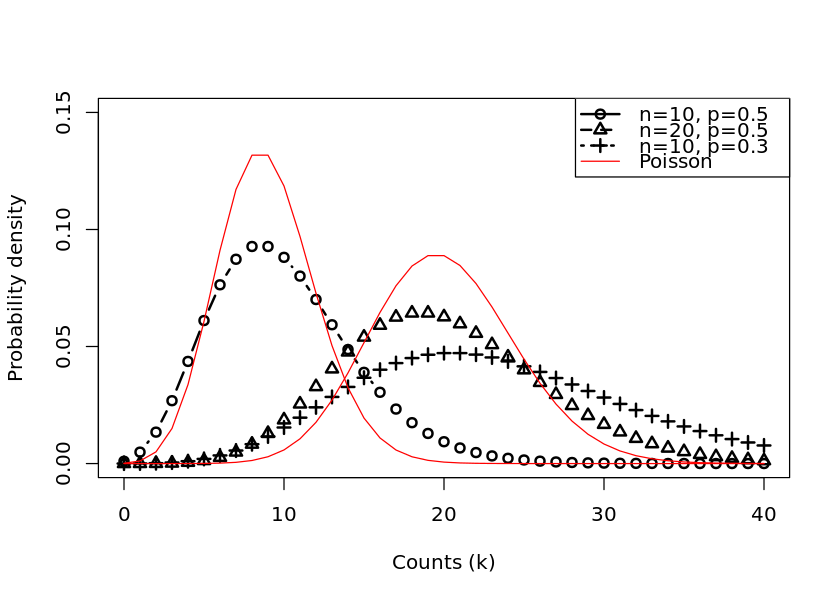

In [7]:
options(repr.plot.height=5, repr.plot.width=7)
plot(x=0:40, y=dnbinom(0:40, size=10, prob=0.5), 
     type="b", lwd=2, ylim=c(0, 0.15),
     xlab="Counts (k)", ylab="Probability density")
lines(x=0:40, y=dnbinom(0:40, size=20, prob=0.5), 
      type="b", lwd=2, lty=2, pch=2)
lines(x=0:40, y=dnbinom(0:40, size=10, prob=0.3),
      type="b", lwd=2, lty=3, pch=3)
lines(x=0:40, y=dpois(0:40, lambda=9), col="red")
lines(x=0:40, y=dpois(0:40, lambda=20), col="red")
legend("topright", lwd=c(2,2,2,1), lty=c(1:3,1), pch=c(1:3,-1), col=c(rep("black", 3), "red"),
       legend=c("n=10, p=0.5", "n=20, p=0.5", "n=10, p=0.3", "Poisson"))

**Figure**: Two Poisson distributions (shown as red lines), and three Negative Binomial (NB) distributions selected for having similarly located peak probabilities. Note the greater dispersion and the tunability of NB distribution. Also note that probabilities are only non-zero defined for integer values.

#  Small samples, large samples, and the Central Limit Theorem

## What is a _sampling distribution_?

It is the distribution of a statistic for many samples taken from one population.
 
1. Take a sample from a population
2. Calculate the sample statistic (e.g. mean)
3. Repeat.  

- The values from (2) form a sampling distribution.
- The standard deviation of the sampling distribution is the _standard error_

- Question: how is this different from a population distribution?

## Example: population and sampling distributions

We observe 100 counts from a Poisson distribution ($\lambda = 2$). 
* Question: is this a population or a sampling distribution?

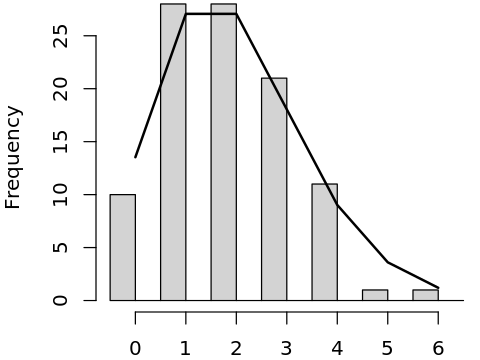

In [8]:
options(repr.plot.height=3, repr.plot.width=3)
set.seed(1)
onesample=rpois(100, lambda=2)
xdens = seq(min(onesample), max(onesample), by=1)
ydens = length(onesample) * dpois(xdens, lambda=2)
par(mar=c(2, 4, 0.1, 0.1))
options(repr.plot.width=4, repr.plot.height=3)
res=hist(onesample, main="", prob=FALSE, col="lightgrey", xlab="", ylim=c(0, max(ydens)),
     breaks=seq(-0.5, round(max(onesample))+0.5, by=0.5))
lines(xdens, ydens, lw=2)

We calculate the *mean* of those 100 counts, and do the same for 1,000 more samples of 100:
* Question: is this a population or a sampling distribution?

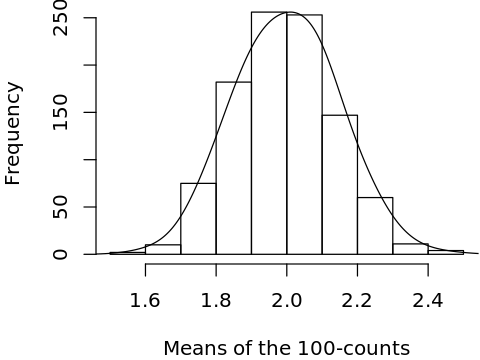

In [9]:
set.seed(1)
samplingdistr=replicate(1000, mean(rpois(100, lambda=2)))
par(mar=c(4, 4, 0.1, 0.1))
res=hist(samplingdistr, xlab="Means of the 100-counts", main="")
dy=density(samplingdistr, adjust=2)
## Note this next step is just an empirical way to put the density line approximately the same scale as the histogram:
dy$y = dy$y / max(dy$y) * max(res$counts)
lines(dy)

## Central Limit Theorem

The "CLT" relates the sampling distribution (of means) to the population distribution.

1. Mean of the population ($\mu$) and of the sampling distribution ($\bar{X}$) are identical
2. Standard deviation of the population ($\sigma$) is related to the standard deviation of the distribution of sample means (*Standard Error* or *SE*) by: 
$$
SE = \sigma / \sqrt{n}
$$
3. For large n, the shape of the sampling distribution of means becomes normal

### CLT 1: equal means

Recall Poisson distributed population and samples of n=30:

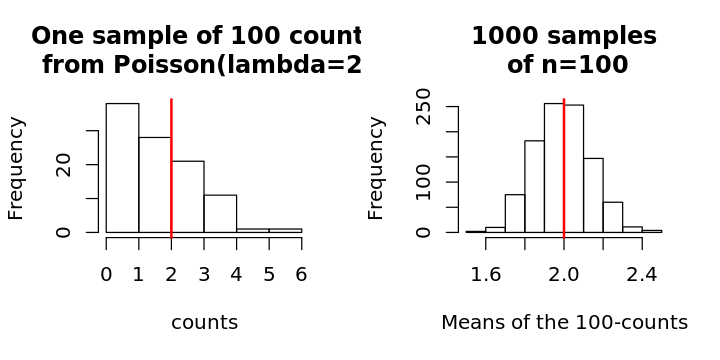

In [10]:
options(repr.plot.width=6, repr.plot.height=3)
par(mfrow=c(1,2))
hist(onesample, main="One sample of 100 counts\n from Poisson(lambda=2)", xlab="counts")
abline(v=2, col="red", lw=2)
res=hist(samplingdistr, xlab="Means of the 100-counts", main="1000 samples\n of n=100")
abline(v=2, col="red", lw=2)

- Distributions are different, but means are the same

### CLT 2: Standard Error

Standard deviation of the sampling distribution is $SE = \sigma / \sqrt{n}$:

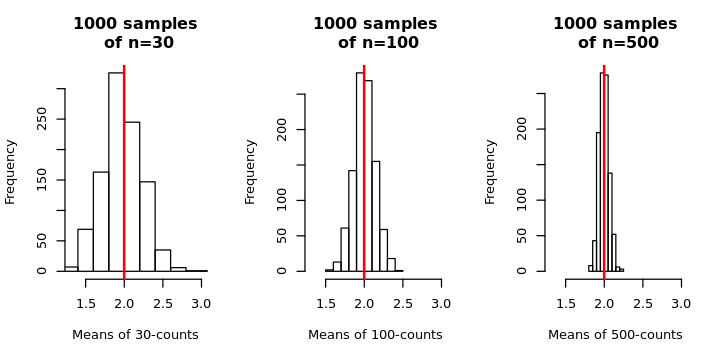

In [11]:
options(repr.plot.width=6, repr.plot.height=3)
par(mfrow=c(1,3))
hist(replicate(1000, mean(rpois(30, lambda=2))), xlim=c(1.3, 3),
     xlab="Means of 30-counts", main="1000 samples\n of n=30")
abline(v=2, col="red", lw=2)
hist(replicate(1000, mean(rpois(100, lambda=2))), xlim=c(1.3, 3),
     xlab="Means of 100-counts", main="1000 samples\n of n=100")
abline(v=2, col="red", lw=2)
hist(replicate(1000, mean(rpois(500, lambda=2))), xlim=c(1.3, 3),
     xlab="Means of 500-counts", main="1000 samples\n of n=500")
abline(v=2, col="red", lw=2)

### CLT 3: large samples

- The distribution of means of large samples is normal. 
    + for large enough n, the population distribution doesn't matter. How large?
    + n < 30: population is normal or close to it
    + n >= 30: skew and outliers are OK
    + n > 500: even extreme population distributions

*Example*: an extremely skewed (log-normal) distribution:

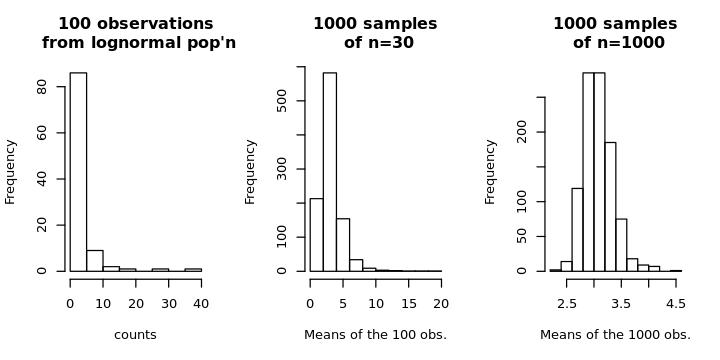

In [12]:
options(repr.plot.width=6, repr.plot.height=3)
par(mfrow=c(1,3))
set.seed(5)
onesample=rlnorm(n=100, sdlog=1.5)
hist(onesample, main="100 observations\n from lognormal pop'n", xlab="counts")
sampling30=replicate(1000, mean(rlnorm(n=30, sdlog=1.5)))
hist(sampling30, xlab="Means of the 100 obs.", main="1000 samples\n of n=30")
sampling1000=replicate(1000, mean(rlnorm(n=1000, sdlog=1.5)))
hist(sampling1000, xlab="Means of the 1000 obs.", main="1000 samples\n of n=1000")

### Practical take-home messages

* For large samples, violations of distributional assumptions have diminishing importance
* _Standard Error_ is the standard deviation of a normally distributed sampling distribution
* The null hypothesis is an assumption about the form of a sampling distribution
    - the p-value is a probability that an observed sample was drawn from this null distribution

# Blocking and stratification

Blocking and stratification are related concepts that group more similar records together. 

## Blocking in experimental design
- The differences between the "blocks" of individuals is "nuisance" variability that we want to control

 <img src="http://faculty.csupueblo.edu/paul.Chacon/156Spr05/images/block.jpg" alt="blocking" style="width:500px"> 

- blocking is typical in biology experiments to:
    + apply an experimental randomization to more homogeneous "blocks" of individuals
    + assign treated and control specimens, or case & control specimens, equally and randomly to batches (really the same as above)

- blocks are normally included as a factor in regression analysis
    + can adjust for nuisance variables afterwards, but *include in experimental design wherever possible*
     
## Stratified random sampling
- done with population sampling

<img src="https://upload.wikimedia.org/wikipedia/commons/a/a2/StratifiedRandomSampling.jpg" alt="SRS" style="width:400px"> 

- divides population into more homogeneous subpopulations
    + during design, strata are normally with predetermined probabilities
 
## Stratification in analysis
- experimental blocks and population strata could either be treated as factors or strata for analysis
    + stratification is necessary when you think a factor in a linear model is inadequate to capture differences between nuisance strata
- observations are:
    + divided into strata
    + strata are analyzed independently
    + results are then averaged across strata

# Differential expression analysis

In the first period we counted the fragments which overlap the genes
in the gene model we specified. From the summarized and annotated count matrix we imported, 
we could use a variety of Bioconductor packages for exploration and
differential expression of the count data, including:
* [DESeq2](http://www.bioconductor.org/packages/DESeq2)
* [edgeR](http://www.bioconductor.org/packages/edgeR)
* [limma](http://www.bioconductor.org/packages/limma) (use Voom method for RNA-seq)

[Schurch *et al.* 2016](https://www.ncbi.nlm.nih.gov/pmc/articles/pmid/27022035/) compared performance of different statistical methods
for RNA-seq using a large number of biological replicates and can help
users to decide which tools make sense to use, and how many
biological replicates are necessary to obtain a certain sensitivity. 

##  Comparison of edgeR / DESeq2 / limma-voom

All excellent, well-documented packages, implementing similar key features:
* Empirical Bayes "regularization" or "shrinkage" of expression variance
   + borrows prior expectation for variance from all genes, reduces false positives in small samples
* Use of model formula, model matrices, and contrasts for flexible differential expression analysis
* Reporting of log fold-change and False Discovery Rate

Some ways they differ are:
* Error terms used (DESeq2 and edgeR use log-linear Generalized Linear Model with negative binomial error term, limma-voom uses linear regression on transformed counts)
* DESeq2 "automagically" handles independent filtering, using Independent Hypothesis Weighting ([IHW package](http://www.bioconductor.org/packages/IHW))
* Speed (limma-voom is much faster and should definitely be used if you have hundreds of samples)
* Approaches to hierarchical modeling, e.g. samples nested within groups
    + limma-voom has a built-in feature for sample correlations (called *duplicateCorrelation*)
* Re-use of core Bioconductor structures (DESeq2 extends *SummarizedExperiment*, edgeR and limma create their own)

Ultimately, I like DESeq2's automatic filtering and re-use of *SummarizedExperiment*. But for large datasets, especially if doing permutations for gene set enrichment analysis, limma with its voom method is far more practical. It is worth noting that for large sample size, it hardly matters which error model you use, owing to the Central Limit Theorem. 

We will continue using [DESeq2](http://www.bioconductor.org/packages/DESeq2), starting from the *SummarizedExperiment* object.

## Running the differential expression pipeline

As we have already specified an experimental design when we created
the *DESeqDataSet*, we can run the differential expression pipeline on
the raw counts with a single call to the function *DESeq*:

In [13]:
suppressPackageStartupMessages({
    library(DESeq2)
    library(airway)
})
data(airway)
dds <- DESeqDataSet(airway, design = ~ cell + dex)
dds <- DESeq(dds)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


This function will print out a message for the various steps it
performs. These are described in more detail in the manual page for
*DESeq*, which can be accessed by typing `?DESeq`. Briefly these are:
the estimation of size factors (controlling for differences in the
sequencing depth of the samples), the estimation of
dispersion values for each gene, and fitting a generalized linear model.

A *DESeqDataSet* is returned that contains all the fitted
parameters within it, and the following section describes how to
extract out results tables of interest from this object.

## Building the results table

Calling *results* without any arguments will extract the estimated
log2 fold changes and *p* values for the last variable in the design
formula. If there are more than 2 levels for this variable, *results*
will extract the results table for a comparison of the last level over
the first level. The comparison is printed at the top of the output:
`dex trt vs untrt`.

In [14]:
res <- results(dds)
res

log2 fold change (MLE): dex untrt vs trt 
Wald test p-value: dex untrt vs trt 
DataFrame with 64102 rows and 6 columns
                 baseMean log2FoldChange     lfcSE       stat       pvalue
                <numeric>      <numeric> <numeric>  <numeric>    <numeric>
ENSG00000000003 708.60217     0.38125397 0.1006560  3.7876937 0.0001520521
ENSG00000000005   0.00000             NA        NA         NA           NA
ENSG00000000419 520.29790    -0.20681259 0.1122218 -1.8428915 0.0653448549
ENSG00000000457 237.16304    -0.03792034 0.1434532 -0.2643394 0.7915183888
ENSG00000000460  57.93263     0.08816367 0.2871677  0.3070111 0.7588349227
...                   ...            ...       ...        ...          ...
LRG_94                  0             NA        NA         NA           NA
LRG_96                  0             NA        NA         NA           NA
LRG_97                  0             NA        NA         NA           NA
LRG_98                  0             NA        NA      

We could have equivalently produced this results table with the
following more specific command. Because `dex` is the last variable in
the design, we could optionally leave off the `contrast` argument to extract
the comparison of the two levels of `dex`.

In [15]:
res <- results(dds, contrast=c("dex","trt","untrt"))

As `res` is a *DataFrame* object, it carries metadata
with information on the meaning of the columns:

In [16]:
mcols(res, use.names = TRUE)

DataFrame with 6 rows and 2 columns
                       type                               description
                <character>                               <character>
baseMean       intermediate mean of normalized counts for all samples
log2FoldChange      results  log2 fold change (MLE): dex trt vs untrt
lfcSE               results          standard error: dex trt vs untrt
stat                results          Wald statistic: dex trt vs untrt
pvalue              results       Wald test p-value: dex trt vs untrt
padj                results                      BH adjusted p-values

The first column, `baseMean`, is a just the average of the normalized
count values, divided by the size factors, taken over all samples in the
*DESeqDataSet*.
The remaining four columns refer to a specific contrast, namely the
comparison of the `trt` level over the `untrt` level for the factor
variable `dex`. We will find out below how to obtain other contrasts.

The column `log2FoldChange` is the effect size estimate. It tells us
how much the gene's expression seems to have changed due to treatment
with dexamethasone in comparison to untreated samples.  This value is
reported on a logarithmic scale to base 2: for example, a log2 fold
change of 1.5 means that the gene's expression is increased by a
multiplicative factor of $2^{1.5} \approx 2.82$.

Of course, this estimate has an uncertainty associated with it, which
is available in the column `lfcSE`, the standard error estimate for
the log2 fold change estimate.  We can also express the uncertainty of
a particular effect size estimate as the result of a statistical
test. The purpose of a test for differential expression is to test
whether the data provides sufficient evidence to conclude that this
value is really different from zero. *DESeq2* performs for each gene a
*hypothesis test* to see whether evidence is sufficient to decide
against the *null hypothesis* that there is zero effect of the treatment
on the gene and that the observed difference between treatment and
control was merely caused by experimental variability (i.e., the type
of variability that you can expect between different
samples in the same treatment group). As usual in statistics, the
result of this test is reported as a *p* value, and it is found in the
column `pvalue`. Remember that a *p* value indicates the probability
that a fold change as strong as the observed one, or even stronger,
would be seen under the situation described by the null hypothesis.

We can also summarize the results with the following line of code,
which reports some additional information, that will be covered in
later sections.

In [17]:
summary(res)


out of 33469 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 2604, 7.8% 
LFC < 0 (down)   : 2212, 6.6% 
outliers [1]     : 0, 0% 
low counts [2]   : 15441, 46% 
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Note that there are many genes with differential expression due to
dexamethasone treatment at the FDR level of 10%. This makes sense, as
the smooth muscle cells of the airway are known to react to
glucocorticoid steroids. However, there are two ways to be more strict
about which set of genes are considered significant:

* lower the false discovery rate threshold (the threshold on `padj` in
  the results table)
* raise the log2 fold change threshold from 0 using the `lfcThreshold`
  argument of *results*

If we lower the false discovery rate threshold, we should also
inform the `results()` function about it, so that the function can use this 
threshold for the optimal independent filtering that it performs:

In [18]:
res.05 <- results(dds, alpha = 0.05)
table(res.05$padj < 0.05)


FALSE  TRUE 
12765  4028 

If we want to raise the log2 fold change threshold, so that we test
for genes that show more substantial changes due to treatment, we
simply supply a value on the log2 scale. For example, by specifying
`lfcThreshold = 1`, we test for genes that show significant effects of
treatment on gene counts more than doubling or less than halving,
because $2^1 = 2$.

In [19]:
resLFC1 <- results(dds, lfcThreshold=1)
table(resLFC1$padj < 0.1)


FALSE  TRUE 
20259   240 

Sometimes a subset of the *p* values in `res` will be `NA` ("not
available"). This is *DESeq*'s way of reporting that all counts for
this gene were zero, and hence no test was applied. In addition, *p*
values can be assigned `NA` if the gene was excluded from analysis
because it contained an extreme count outlier. For more information,
see the outlier detection section of the *DESeq2* vignette.

If you use the results from an R analysis package in published
research, you can find the proper citation for the software by typing
`citation("pkgName")`, where you would substitute the name of the
package for `pkgName`.  Citing methods papers helps to support and
reward the individuals who put time into open source software for
genomic data analysis.

## Other comparisons

In general, the results for a comparison of any two levels of a
variable can be extracted using the `contrast` argument to
*results*. The user should specify three values: the name of the
variable, the name of the level for the numerator, and the name of the
level for the denominator. Here we extract results for the log2 of the
fold change of one cell line over another:

In [20]:
results(dds, contrast = c("cell", "N061011", "N61311"))

log2 fold change (MLE): cell N061011 vs N61311 
Wald test p-value: cell N061011 vs N61311 
DataFrame with 64102 rows and 6 columns
                 baseMean log2FoldChange     lfcSE        stat     pvalue
                <numeric>      <numeric> <numeric>   <numeric>  <numeric>
ENSG00000000003 708.60217     0.30632635 0.1435330  2.13418730 0.03282745
ENSG00000000005   0.00000             NA        NA          NA         NA
ENSG00000000419 520.29790    -0.05404672 0.1597205 -0.33838315 0.73507447
ENSG00000000457 237.16304     0.01630854 0.2030380  0.08032262 0.93598067
ENSG00000000460  57.93263     0.27912686 0.4007042  0.69659087 0.48605887
...                   ...            ...       ...         ...        ...
LRG_94                  0             NA        NA          NA         NA
LRG_96                  0             NA        NA          NA         NA
LRG_97                  0             NA        NA          NA         NA
LRG_98                  0             NA        NA     

There are additional ways to build results tables for certain
comparisons after running *DESeq* once.
If results for an interaction term are desired, the `name`
argument of *results* should be used. Please see the 
help page for the *results* function for details on the additional
ways to build results tables. In particular, the **Examples** section of
the help page for *results* gives some pertinent examples.

## Multiple testing

In high-throughput biology, we are careful to not use the *p* values
directly as evidence against the null, but to correct for
*multiple testing*. What would happen if we were to simply threshold
the *p* values at a low value, say 0.05? There are
5676 genes with a *p* value
below 0.05 among the 33469 genes for which the
test succeeded in reporting a *p* value:

In [21]:
sum(res$pvalue < 0.05, na.rm=TRUE)

[1] 5676

In [22]:
sum(!is.na(res$pvalue))

[1] 33469

Now, assume for a moment that the null hypothesis is true for all
genes, i.e., no gene is affected by the treatment with
dexamethasone. Then, by the definition of the *p* value, we expect up to
5% of the genes to have a *p* value below 0.05. This amounts to
1673 genes.
If we just considered the list of genes with a *p* value below 0.05 as
differentially expressed, this list should therefore be expected to
contain up to
1673 /
5676 =
29%
 false positives.

*DESeq2* uses the [Benjamini-Hochberg (BH)](https://www.jstor.org/stable) adjustment as implemented in
the base R *p.adjust* function; in brief, this method calculates for
each gene an adjusted *p* value that answers the following question:
if one called significant all genes with an adjusted *p* value less than or
equal to this gene's adjusted *p* value threshold, what would be the fraction
of false positives (the *false discovery rate*, FDR) among them, in
the sense of the calculation outlined above? These values, called the
BH-adjusted *p* values, are given in the column `padj` of the `res`
object.

The FDR is a useful statistic for many high-throughput
experiments, as we are often interested in reporting or focusing on a
set of interesting genes, and we would like to put an upper bound on the
percent of false positives in this set. 

Hence, if we consider a fraction of 10% false positives acceptable,
we can consider all genes with an adjusted *p* value below 10% = 0.1
as significant. How many such genes are there?

In [23]:
sum(res$padj < 0.1, na.rm=TRUE)

[1] 4816

In [24]:
## [1] 4816

We subset the results table to these genes and then sort it by the
log2 fold change estimate to get the significant genes with the
strongest down-regulation:

In [25]:
resSig <- subset(res, padj < 0.1)
head(resSig[ order(resSig$log2FoldChange), ])

log2 fold change (MLE): dex trt vs untrt 
Wald test p-value: dex trt vs untrt 
DataFrame with 6 rows and 6 columns
                 baseMean log2FoldChange     lfcSE      stat       pvalue
                <numeric>      <numeric> <numeric> <numeric>    <numeric>
ENSG00000128285  6.624741      -5.325910 1.2578850 -4.234020 2.295505e-05
ENSG00000267339 26.233573      -4.611555 0.6731316 -6.850896 7.338891e-12
ENSG00000019186 14.087605      -4.325920 0.8578242 -5.042898 4.585343e-07
ENSG00000183454  5.804171      -4.264085 1.1669488 -3.654047 2.581395e-04
ENSG00000146006 46.807597      -4.211875 0.5288795 -7.963771 1.668744e-15
ENSG00000141469 53.436528      -4.124796 1.1297987 -3.650913 2.613100e-04
                        padj
                   <numeric>
ENSG00000128285 2.382462e-04
ENSG00000267339 2.057629e-10
ENSG00000019186 6.623763e-06
ENSG00000183454 2.051913e-03
ENSG00000146006 7.179979e-14
ENSG00000141469 2.073458e-03

...and with the strongest up-regulation:

In [26]:
head(resSig[ order(resSig$log2FoldChange, decreasing = TRUE), ])

log2 fold change (MLE): dex trt vs untrt 
Wald test p-value: dex trt vs untrt 
DataFrame with 6 rows and 6 columns
                  baseMean log2FoldChange     lfcSE      stat       pvalue
                 <numeric>      <numeric> <numeric> <numeric>    <numeric>
ENSG00000179593  67.243048       9.505975 1.0545122  9.014571 1.976428e-19
ENSG00000109906 385.071029       7.352626 0.5363887 13.707645 9.137621e-43
ENSG00000250978  56.318194       6.327392 0.6778154  9.334979 1.010116e-20
ENSG00000132518   5.654654       5.885115 1.3241380  4.444488 8.810142e-06
ENSG00000127954 286.384119       5.207158 0.4930818 10.560435 4.545484e-26
ENSG00000249364   8.839061       5.098168 1.1596864  4.396161 1.101821e-05
                        padj
                   <numeric>
ENSG00000179593 1.254614e-17
ENSG00000109906 2.256617e-40
ENSG00000250978 7.226340e-19
ENSG00000132518 1.002077e-04
ENSG00000127954 5.058395e-24
ENSG00000249364 1.226150e-04

# Diagnostic plots

## MA-plot

An *MA-plot* ([Dudoit et al., Statistica Sinica, 2002](http://wwwf.imperial.ac.uk/~das01/BioinformaticsMSc/Papers/sinica.final.pdf)) provides a useful overview for
the distribution of the estimated coefficients in the model,
e.g. the comparisons of interest, across all genes.
On the y-axis, the "M" stands for "minus" --
subtraction of log values is equivalent to the log of the ratio -- and
on the x-axis, the "A" stands for "average". You may hear this plot
also referred to as a mean-difference plot, or a Bland-Altman plot.

Before making the MA-plot, we use the
*lfcShrink* function to shrink the log2 fold changes for the
comparison of dex treated vs untreated samples:

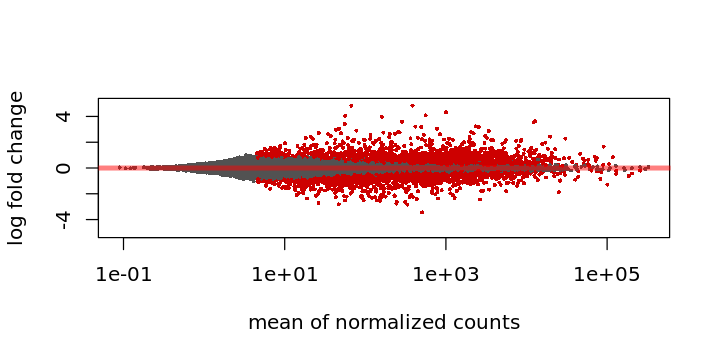

In [27]:
res <- lfcShrink(dds, contrast=c("dex","trt","untrt"), res=res)
plotMA(res, ylim = c(-5, 5))

**An MA-plot of changes induced by treatment.**
The log2 fold change for a particular
comparison is plotted on the y-axis and the average of the counts
normalized by size factor is shown on the x-axis.
Each gene is represented with a dot. Genes with an adjusted *p* value
below a threshold (here 0.1, the default) are shown in red.

The *DESeq2* package uses a Bayesian procedure to moderate (or
"shrink") log2 fold changes from genes with very low counts and highly
variable counts, as can be seen by the narrowing of the vertical
spread of points on the left side of the MA-plot. As shown above, the
*lfcShrink* function performs this operation.  For a detailed
explanation of the rationale of moderated fold changes, please see the
*DESeq2* paper ([Love and Huber, Genome Biology, 2014](http://wwwf.imperial.ac.uk/~das01/BioinformaticsMSc/Papers/sinica.final.pdf)).

If we had not used statistical moderation to shrink the noisy log2
fold changes, we would have instead seen the following plot:

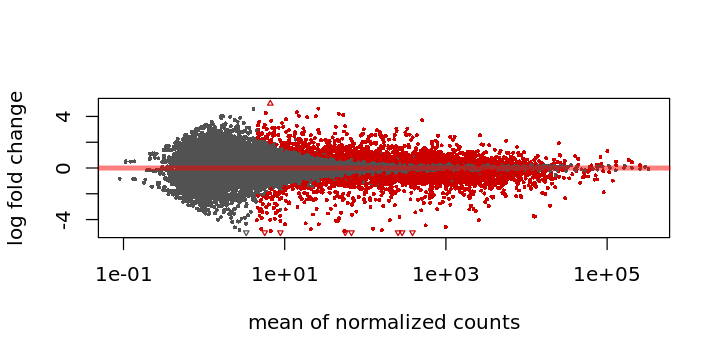

In [28]:
res.noshr <- results(dds)
plotMA(res.noshr, ylim = c(-5, 5))

![](BrownCOBREDay2Session2_files/figure-html/plotmaNoShr-1.png)<!-- -->

We can label individual points on the MA-plot as well. Here we use the
*with* R function to plot a circle and text for a selected row of the
results object. Within the *with* function, only the `baseMean` and
`log2FoldChange` values for the selected rows of `res` are used.

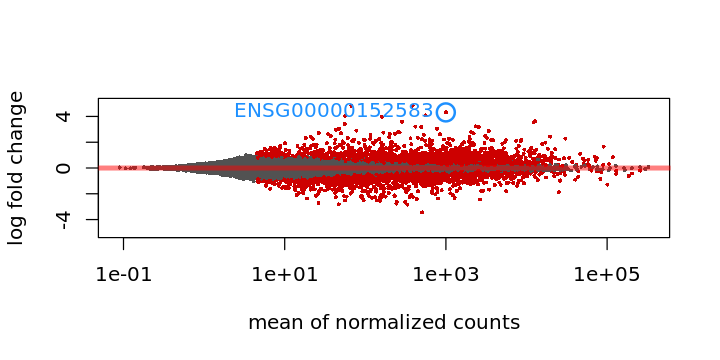

In [29]:
plotMA(res, ylim = c(-5,5))
topGene <- rownames(res)[which.min(res$padj)]
with(res[topGene, ], {
  points(baseMean, log2FoldChange, col="dodgerblue", cex=2, lwd=2)
  text(baseMean, log2FoldChange, topGene, pos=2, col="dodgerblue")
})

![](BrownCOBREDay2Session2_files/figure-html/plotmalabel-1.png)<!-- -->

Another useful diagnostic plot is the histogram of the *p* values
(figure below). This plot is best formed by excluding genes with very
small counts, which otherwise generate spikes in the histogram.

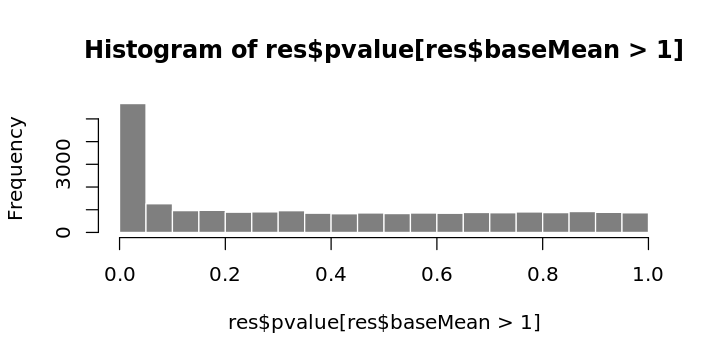

In [30]:
hist(res$pvalue[res$baseMean > 1], breaks = 0:20/20,
     col = "grey50", border = "white")

**Histogram of *p* values for genes with mean normalized count larger than 1.**

## Volcano plot

A typical volcano plot is a scatterplot of $-log_{10}$(p-value) vs. $log_2$(fold-change). It allows you to visualize the difference in expression between groups against the statistical significance of that difference. Some things to look for:
* are diffentially expressed genes skewed towards up or down-regulation?
* are there a lot of significant but very low fold-change genes? This can result from a confounded batch effect.

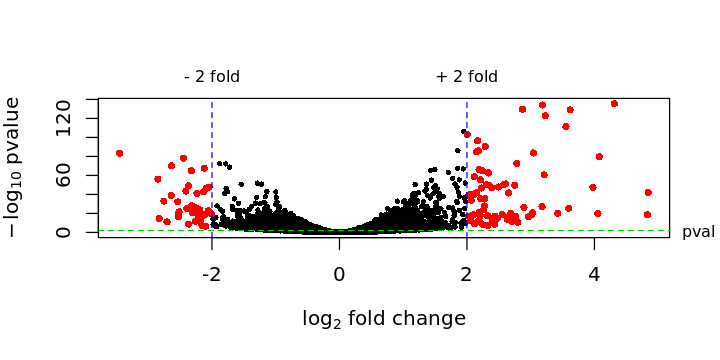

In [31]:
volcanoPlot <- function(res, lfc=2, pval=0.01){
    tab = data.frame(logFC = res$log2FoldChange, negLogPval = -log10(res$pvalue))
    plot(tab, pch = 16, cex = 0.6, xlab = expression(log[2]~fold~change), ylab = expression(-log[10]~pvalue))
    signGenes = (abs(tab$logFC) > lfc & tab$negLogPval > -log10(pval))
    points(tab[signGenes, ], pch = 16, cex = 0.8, col = "red") 
    abline(h = -log10(pval), col = "green3", lty = 2) 
    abline(v = c(-lfc, lfc), col = "blue", lty = 2) 
    mtext(paste("pval =", pval), side = 4, at = -log10(pval), cex = 0.8, line = 0.5, las = 1) 
    mtext(c(paste("-", lfc, "fold"), paste("+", lfc, "fold")), side = 3, at = c(-lfc, lfc), cex = 0.8, line = 0.5)
}
volcanoPlot(res)

# Visualizing differential expression results

## Counts plot

A quick way to visualize the counts for a particular gene is to use
the *plotCounts* function that takes as arguments the
*DESeqDataSet*, a gene name, and the group over which to plot the
counts (figure below).

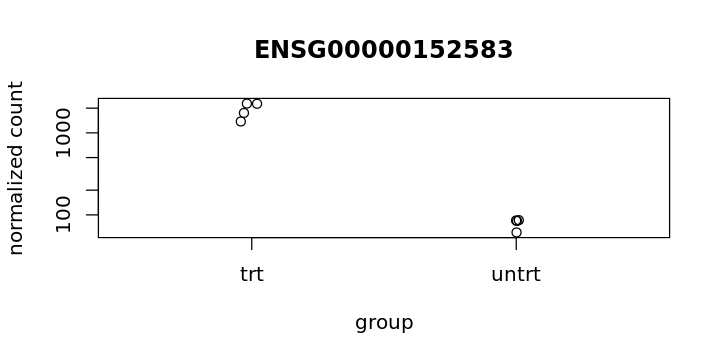

In [32]:
topGene <- rownames(res)[which.min(res$padj)]
plotCounts(dds, gene = topGene, intgroup=c("dex"))

![](BrownCOBREDay2Session2_files/figure-html/plotcounts-1.png)<!-- -->

**Normalized counts for a single gene over treatment group.**

We can also make custom plots using the *ggplot* function from the
[ggplot2](http://ggplot2.org/) package (figures below).

Loading required package: ggplot2


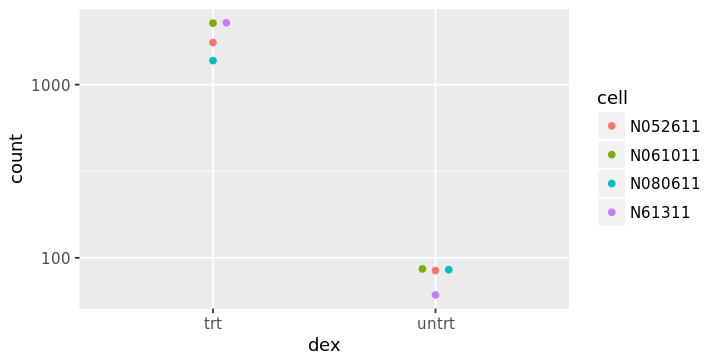

In [33]:
library("ggbeeswarm")
geneCounts <- plotCounts(dds, gene = topGene, intgroup = c("dex","cell"),
                         returnData = TRUE)
ggplot(geneCounts, aes(x = dex, y = count, color = cell)) +
  scale_y_log10() +  geom_beeswarm(cex = 3)

![](BrownCOBREDay2Session2_files/figure-html/ggplotcountsjitter-1.png)<!-- -->

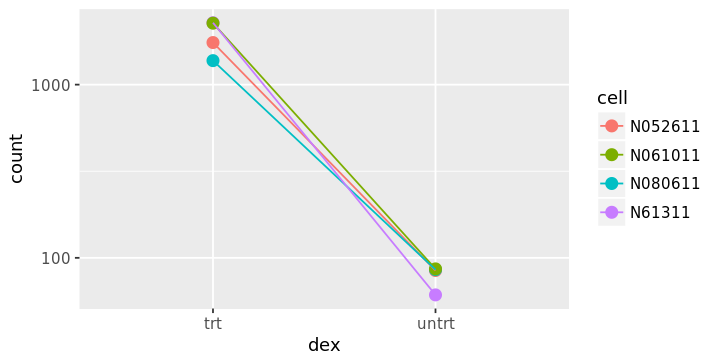

In [34]:
ggplot(geneCounts, aes(x = dex, y = count, color = cell, group = cell)) +
  scale_y_log10() + geom_point(size = 3) + geom_line()

![](BrownCOBREDay2Session2_files/figure-html/ggplotcountsgroup-1.png)<!-- -->

**Normalized counts with lines connecting cell lines.**
Note that the *DESeq* test actually takes into account the cell line
effect, so this figure more closely depicts the difference being tested.

## Gene clustering

In the sample distance heatmap made previously, the dendrogram at the
side shows us a hierarchical clustering of the samples. Such a
clustering can also be performed for the genes.  Since the clustering
is only relevant for genes that actually carry a signal, one usually
would only cluster a subset of the most highly variable genes. Here,
for demonstration, let us select the 20 genes with the highest
variance across samples. We will work with the *rlog* transformed
counts:

In [35]:
rld <- rlog(dds, blind=FALSE, fitType="mean")
suppressPackageStartupMessages(library(genefilter))
topVarGenes <- head(order(rowVars(assay(rld)), decreasing = TRUE), 20)

The heatmap becomes more interesting if we do not look at absolute
expression strength but rather at the amount by which each gene
deviates in a specific sample from the gene's average across all
samples. Hence, we center each genes' values across samples,
and plot a heatmap (figure below). We provide a *data.frame* that instructs the
*pheatmap* function how to label the columns.

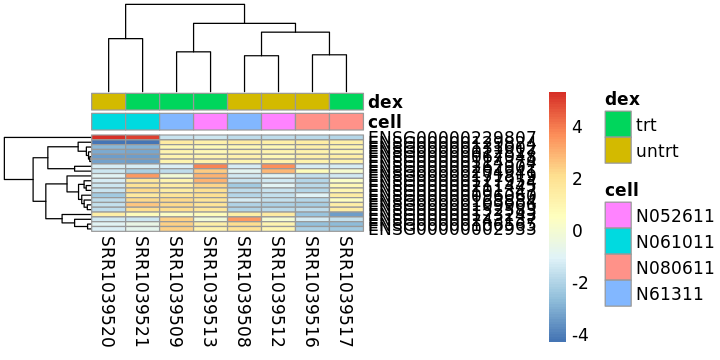

In [36]:
library(pheatmap)
mat  <- assay(rld)[ topVarGenes, ]
mat  <- mat - rowMeans(mat)
anno <- as.data.frame(colData(rld)[, c("cell","dex")])
pheatmap(mat, annotation_col = anno)

![](BrownCOBREDay2Session2_files/figure-html/genescluster-1.png)<!-- -->

**Heatmap of relative rlog-transformed values across samples.**
Treatment status and cell line information are shown with colored bars
at the top of the heatmap.
Blocks of genes that covary across patients. Note that
a set of genes at the top of the heatmap are separating the N061011
cell line from the others. In the center of the heatmap, we see a set
of genes for which the dexamethasone treated samples have higher gene
expression. 

## Plotting fold changes in genomic space

If we have used the *summarizeOverlaps* function to count the reads,
then our *DESeqDataSet* object is built on top of ready-to-use
Bioconductor objects specifying the genomic coordinates of the genes. We
can therefore easily plot our differential expression results in
genomic space. While the *results* function by default returns a
*DataFrame*, using the `format` argument, we can ask for *GRanges* or
*GRangesList* output.

In [37]:
resGR <- results(dds, lfcThreshold = 1, format = "GRanges")

rowRanges is GRangesList, performing unlist(range(x)) on the rowRanges


In [38]:
resGR

GRanges object with 64102 ranges and 6 metadata columns:
                  seqnames                 ranges strand |         baseMean
                     <Rle>              <IRanges>  <Rle> |        <numeric>
  ENSG00000000003        X [ 99883667,  99894988]      - | 708.602169691234
  ENSG00000000005        X [ 99839799,  99854882]      + |                0
  ENSG00000000419       20 [ 49551404,  49575092]      - | 520.297900552084
  ENSG00000000457        1 [169818772, 169863408]      - | 237.163036796015
  ENSG00000000460        1 [169631245, 169823221]      + | 57.9326331250967
              ...      ...                    ...    ... .              ...
           LRG_94   LRG_94          [5001, 10428]      + |                0
           LRG_96   LRG_96          [5001, 91210]      + |                0
           LRG_97   LRG_97          [5001, 23996]      + |                0
           LRG_98   LRG_98          [5001, 16750]      + |                0
           LRG_99   LRG_99     

We need to add the symbol again for labeling the genes on the plot:

In [39]:
library(org.Hs.eg.db)
resGR$symbol <- mapIds(org.Hs.eg.db, names(resGR), "SYMBOL", "ENSEMBL")

Loading required package: AnnotationDbi

'select()' returned 1:many mapping between keys and columns


We will use the [Gviz](http://www.bioconductor.org/packages/Gviz) package for plotting the GRanges
and associated metadata: the log fold changes due to dexamethasone treatment.

In [40]:
suppressPackageStartupMessages(library(Gviz))

The following code chunk specifies a window of 1 million base pairs
upstream and downstream from the gene with the smallest *p* value.
We create a subset of our full results, for genes within the window.
We add the gene symbol as a name if the symbol exists and is not duplicated in
our subset.

In [41]:
window <- resGR[topGene] + 1e6
strand(window) <- "*"
resGRsub <- resGR[resGR %over% window]
naOrDup <- is.na(resGRsub$symbol) | duplicated(resGRsub$symbol)
resGRsub$group <- ifelse(naOrDup, names(resGRsub), resGRsub$symbol)

We create a vector specifying if the genes in this subset had a low
value of `padj`.

In [42]:
status <- factor(ifelse(resGRsub$padj < 0.1 & !is.na(resGRsub$padj),
                     "sig", "notsig"))

We can then plot the results using [Gviz](http://www.bioconductor.org/packages/Gviz) functions
(figure below). We
create an axis track specifying our location in the genome, a track
that will show the genes and their names, colored by significance,
and a data track that will draw vertical bars showing the moderated
log fold change produced by *DESeq2*, which we know are only large
when the effect is well supported by the information in the counts.

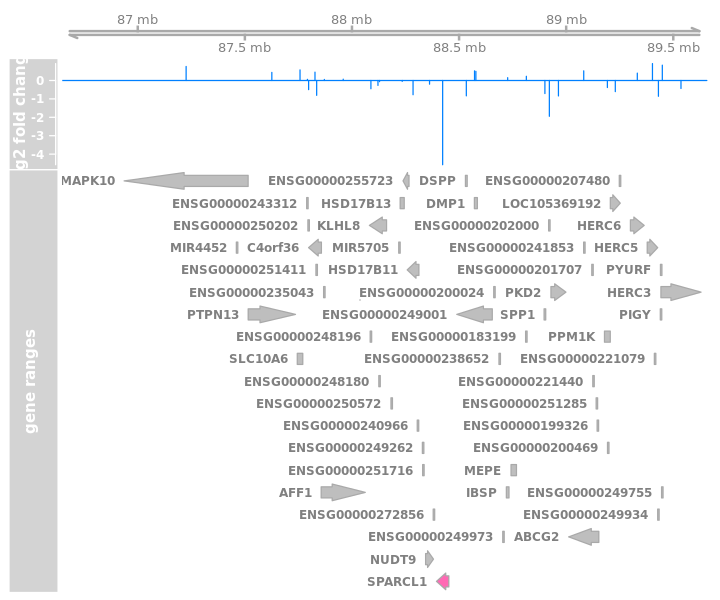

In [43]:
options(repr.plot.height=5)
options(ucscChromosomeNames = FALSE)
g <- GenomeAxisTrack()
a <- AnnotationTrack(resGRsub, name = "gene ranges", feature = status)
d <- DataTrack(resGRsub, data = "log2FoldChange", baseline = 0,
               type = "h", name = "log2 fold change", strand = "+")
plotTracks(list(g, d, a), groupAnnotation = "group",
           notsig = "grey", sig = "hotpink")

**log2 fold changes in genomic region surrounding the gene with smallest
  adjusted *p* value.** Genes highlighted in pink have adjusted *p*
  value less than 0.1.

#  Correcting for batch effects

Suppose we did not know that there were different cell lines involved
in the experiment, only that there was treatment with
dexamethasone. The cell line effect on the counts then would represent
some hidden and unwanted variation that might be affecting
many or all of the genes in the dataset. We can use statistical
methods designed for RNA-seq from the 
[sva](http://www.bioconductor.org/packages/Gviz) package to
detect such groupings of the samples, and then we can add these to the
*DESeqDataSet* design, in order to account for them. The *SVA*
package uses the term *surrogate variables* for the estimated
variables that we want to account for in our analysis. Another
package for detecting hidden batches is the [RUVSeq](http://www.bioconductor.org/packages/RUVSeq)
package, with the acronym "Remove Unwanted Variation".

In [44]:
suppressPackageStartupMessages(library(sva))

Below we obtain a matrix of normalized counts for which the average count across
samples is larger than 1. As we described above, we are trying to
recover any hidden batch effects, supposing that we do not know the
cell line information. So we use a full model matrix with the
*dex* variable, and a reduced, or null, model matrix with only
an intercept term. Finally we specify that we want to estimate 2
surrogate variables. For more information read the manual page for the
*svaseq* function by typing `?svaseq`.

In [45]:
dat  <- counts(dds, normalized = TRUE)
idx  <- rowMeans(dat) > 1
dat  <- dat[idx, ]
mod  <- model.matrix(~ dex, colData(dds))
mod0 <- model.matrix(~   1, colData(dds))
svseq <- svaseq(dat, mod, mod0, n.sv = 2)

Number of significant surrogate variables is:  2 
Iteration (out of 5 ):1  2  3  4  5  

In [46]:
svseq$sv

0.2481108,-0.52600157
0.2629867,-0.58115433
0.1502704,0.27428267
0.2023800,0.38419545
-0.6086586,-0.07854931
-0.6101210,-0.02923693
0.1788509,0.25708985
0.1761807,0.29937417


Because we actually do know the cell lines, we can see how well the
SVA method did at recovering these variables (figure below).

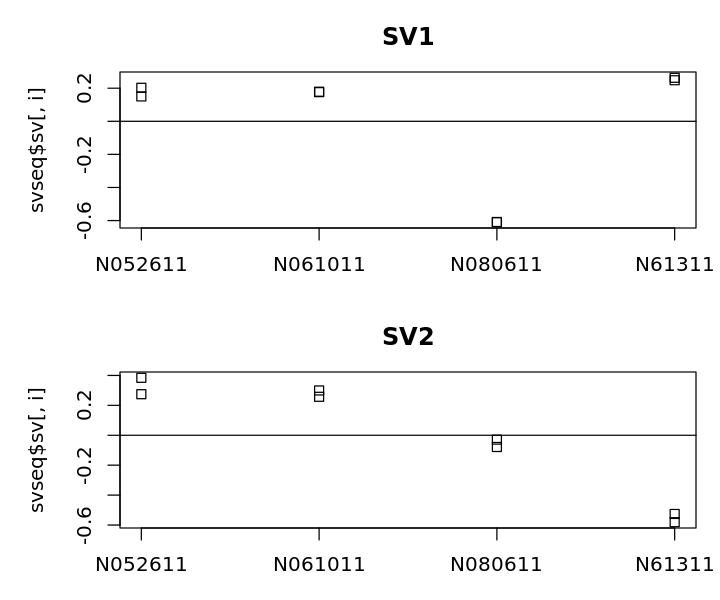

In [47]:
options(repr.plot.height=5)
par(mfrow = c(2, 1), mar = c(3,5,3,1))
for (i in 1:2) {
  stripchart(svseq$sv[, i] ~ dds$cell, vertical = TRUE, main = paste0("SV", i))
  abline(h = 0)
 }

![](BrownCOBREDay2Session2_files/figure-html/svaplot-1.png)<!-- -->

**Surrogate variables 1 and 2 plotted over cell line.**
Here, we know the hidden source of variation (cell line), and
therefore can see how the SVA procedure is able to identify a source
of variation which is correlated with cell line.

Finally, in order to use SVA to remove any effect on the counts from
our surrogate variables, we simply add these two surrogate variables
as columns to the *DESeqDataSet* and then add them to the design:

In [48]:
ddssva <- dds
ddssva$SV1 <- svseq$sv[,1]
ddssva$SV2 <- svseq$sv[,2]
design(ddssva) <- ~ SV1 + SV2 + dex

We could then produce results controlling for surrogate variables by
running *DESeq* with the new design:

In [ ]:
DESeq(ddssva)

using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
